In [1]:
# %cd ../../.. # used when not running from the repo root

In [2]:
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from functools import lru_cache

from dotless_arabic.processing import undot

In [3]:
def tokens_counter(tokenizer_name,is_dotted=True,dataset_name='aggregated'):
    # loading the tokens frequency json file
    if is_dotted is True:
        counts_file_name = f'dotted_{tokenizer_name}.json'
    else:
        counts_file_name = f'undotted_{tokenizer_name}.json'
    counts_file_path = f'dotless_arabic/datasets/{dataset_name}/tokens_count/{counts_file_name}'
    counter = json.load(open(counts_file_path))
    return counter

In [4]:
# in this notebook, we will only consider the aggregated dataset as it holds all tokens
words_counter = tokens_counter(tokenizer_name='WordTokenizer')
farasa_counter = tokens_counter(tokenizer_name='FarasaMorphologicalTokenizer')
disjoint_counter = tokens_counter(tokenizer_name='DisjointLetterTokenizer')


In [5]:
# @lru_cache()
# def get_x_y_points(counter_json_str,verbose=True,maximum_percentage=100,use_tqdm=True):
#     counter = json.loads(counter_json_str)
#     assert 2 <= maximum_percentage <=100 , f'maximum percentage should be between 2,100'
#     thresholds = list(map(lambda item: round(0.01*item,2), range(1,maximum_percentage)))
#     words = list(counter.keys())
#     X,Y = list(),list()
#     thresholds = tqdm(thresholds) if use_tqdm else thresholds
#     for threshold in thresholds:
#         top_words = words[:int(threshold*len(words))]
#         words_size = len(top_words)
#         undotted_words = list(map(lambda word: undot(word,process_first=True),top_words))
#         undotted_words_size = len(set(undotted_words))
#         reduction_ratio = 1-(undotted_words_size/words_size)
#         X.append(round(100*threshold,2))
#         Y.append(round(100*reduction_ratio,2))
#         if verbose:
#             print(
#                 f'top {int(threshold*100)}% words: {words_size:,}',
#                 f'undotted: {undotted_words_size:,}',
#                 f'reduction ratio: {round(100*reduction_ratio,2):,}%',
#                 )
#     return X,Y

In [6]:
# A Faster implementation using dynamic programming
@lru_cache
def get_x_y_points(counter_json_str, verbose=True, maximum_percentage=100, use_tqdm=True):
    # Load the counter from JSON and validate percentage range
    counter = json.loads(counter_json_str)
    assert 2 <= maximum_percentage <= 100, 'maximum percentage should be between 2 and 100'
    
    # Create threshold percentages and initialize variables
    total_words_count = len(counter)
    thresholds = [i / 100 for i in range(1, maximum_percentage)]
    
    thresholds = tqdm(thresholds,disable=not use_tqdm)
    
    X, Y = [], []
    words = list(counter.keys())
    
    # Cached results
    undotted_words_cache = set()
    previous_threshold_count = 0
    
    for threshold in thresholds:
        current_threshold_count = int(threshold * total_words_count)
        new_words = words[previous_threshold_count:current_threshold_count]
        
        # Update undotted words cache
        new_undotted_words = {undot(word, process_first=True) for word in new_words}
        undotted_words_cache.update(new_undotted_words)
        
        undotted_words_count = len(undotted_words_cache)
        reduction_ratio = 1 - (undotted_words_count / current_threshold_count)
        
        # Store the results
        X.append(round(100 * threshold, 2))
        Y.append(round(100 * reduction_ratio, 2))
        
        if verbose:
            print(f'top {threshold * 100:.0f}% words: {current_threshold_count:,}',
                  f'undotted: {undotted_words_count:,}',
                  f'reduction ratio: {100 * reduction_ratio:.2f}%')
        
        # Update the previous threshold word count for the next iteration
        previous_threshold_count = current_threshold_count
    
    return X, Y

In [7]:
# testing the function
get_x_y_points(counter_json_str=json.dumps(disjoint_counter),maximum_percentage=10)

  0%|          | 0/9 [00:00<?, ?it/s]

top 1% words: 4,020 undotted: 2,496 reduction ratio: 37.91%
top 2% words: 8,040 undotted: 4,706 reduction ratio: 41.47%
top 3% words: 12,060 undotted: 6,790 reduction ratio: 43.70%
top 4% words: 16,080 undotted: 8,846 reduction ratio: 44.99%
top 5% words: 20,100 undotted: 10,811 reduction ratio: 46.21%
top 6% words: 24,121 undotted: 12,779 reduction ratio: 47.02%
top 7% words: 28,141 undotted: 14,665 reduction ratio: 47.89%
top 8% words: 32,161 undotted: 16,547 reduction ratio: 48.55%
top 9% words: 36,181 undotted: 18,338 reduction ratio: 49.32%


([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
 [37.91, 41.47, 43.7, 44.99, 46.21, 47.02, 47.89, 48.55, 49.32])

In [8]:
def plot(
    counters=[
        words_counter,
        farasa_counter,
        disjoint_counter,
    ],
    counters_names=[
        'words',
        'farasa subwords',
        'disjoint subwords'
    ]
):
    plt.figure(figsize=(16,12),dpi=300)
    plt.rc('font',size=15)
    for counter,counter_name in list(zip(counters,counters_names)):
        X,Y = get_x_y_points(counter_json_str=json.dumps(counter),verbose=False)
        plt.plot(
            X,
            Y,
            label=f'{counter_name}',
        )
    plt.xlabel('ordered dotted vocabulary by frequency (percentage)',fontsize=17)
    plt.ylabel('dotless to dotted vocabulary reduction (percentage)',fontsize=17,)
    plt.legend(loc='best',fontsize=15)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

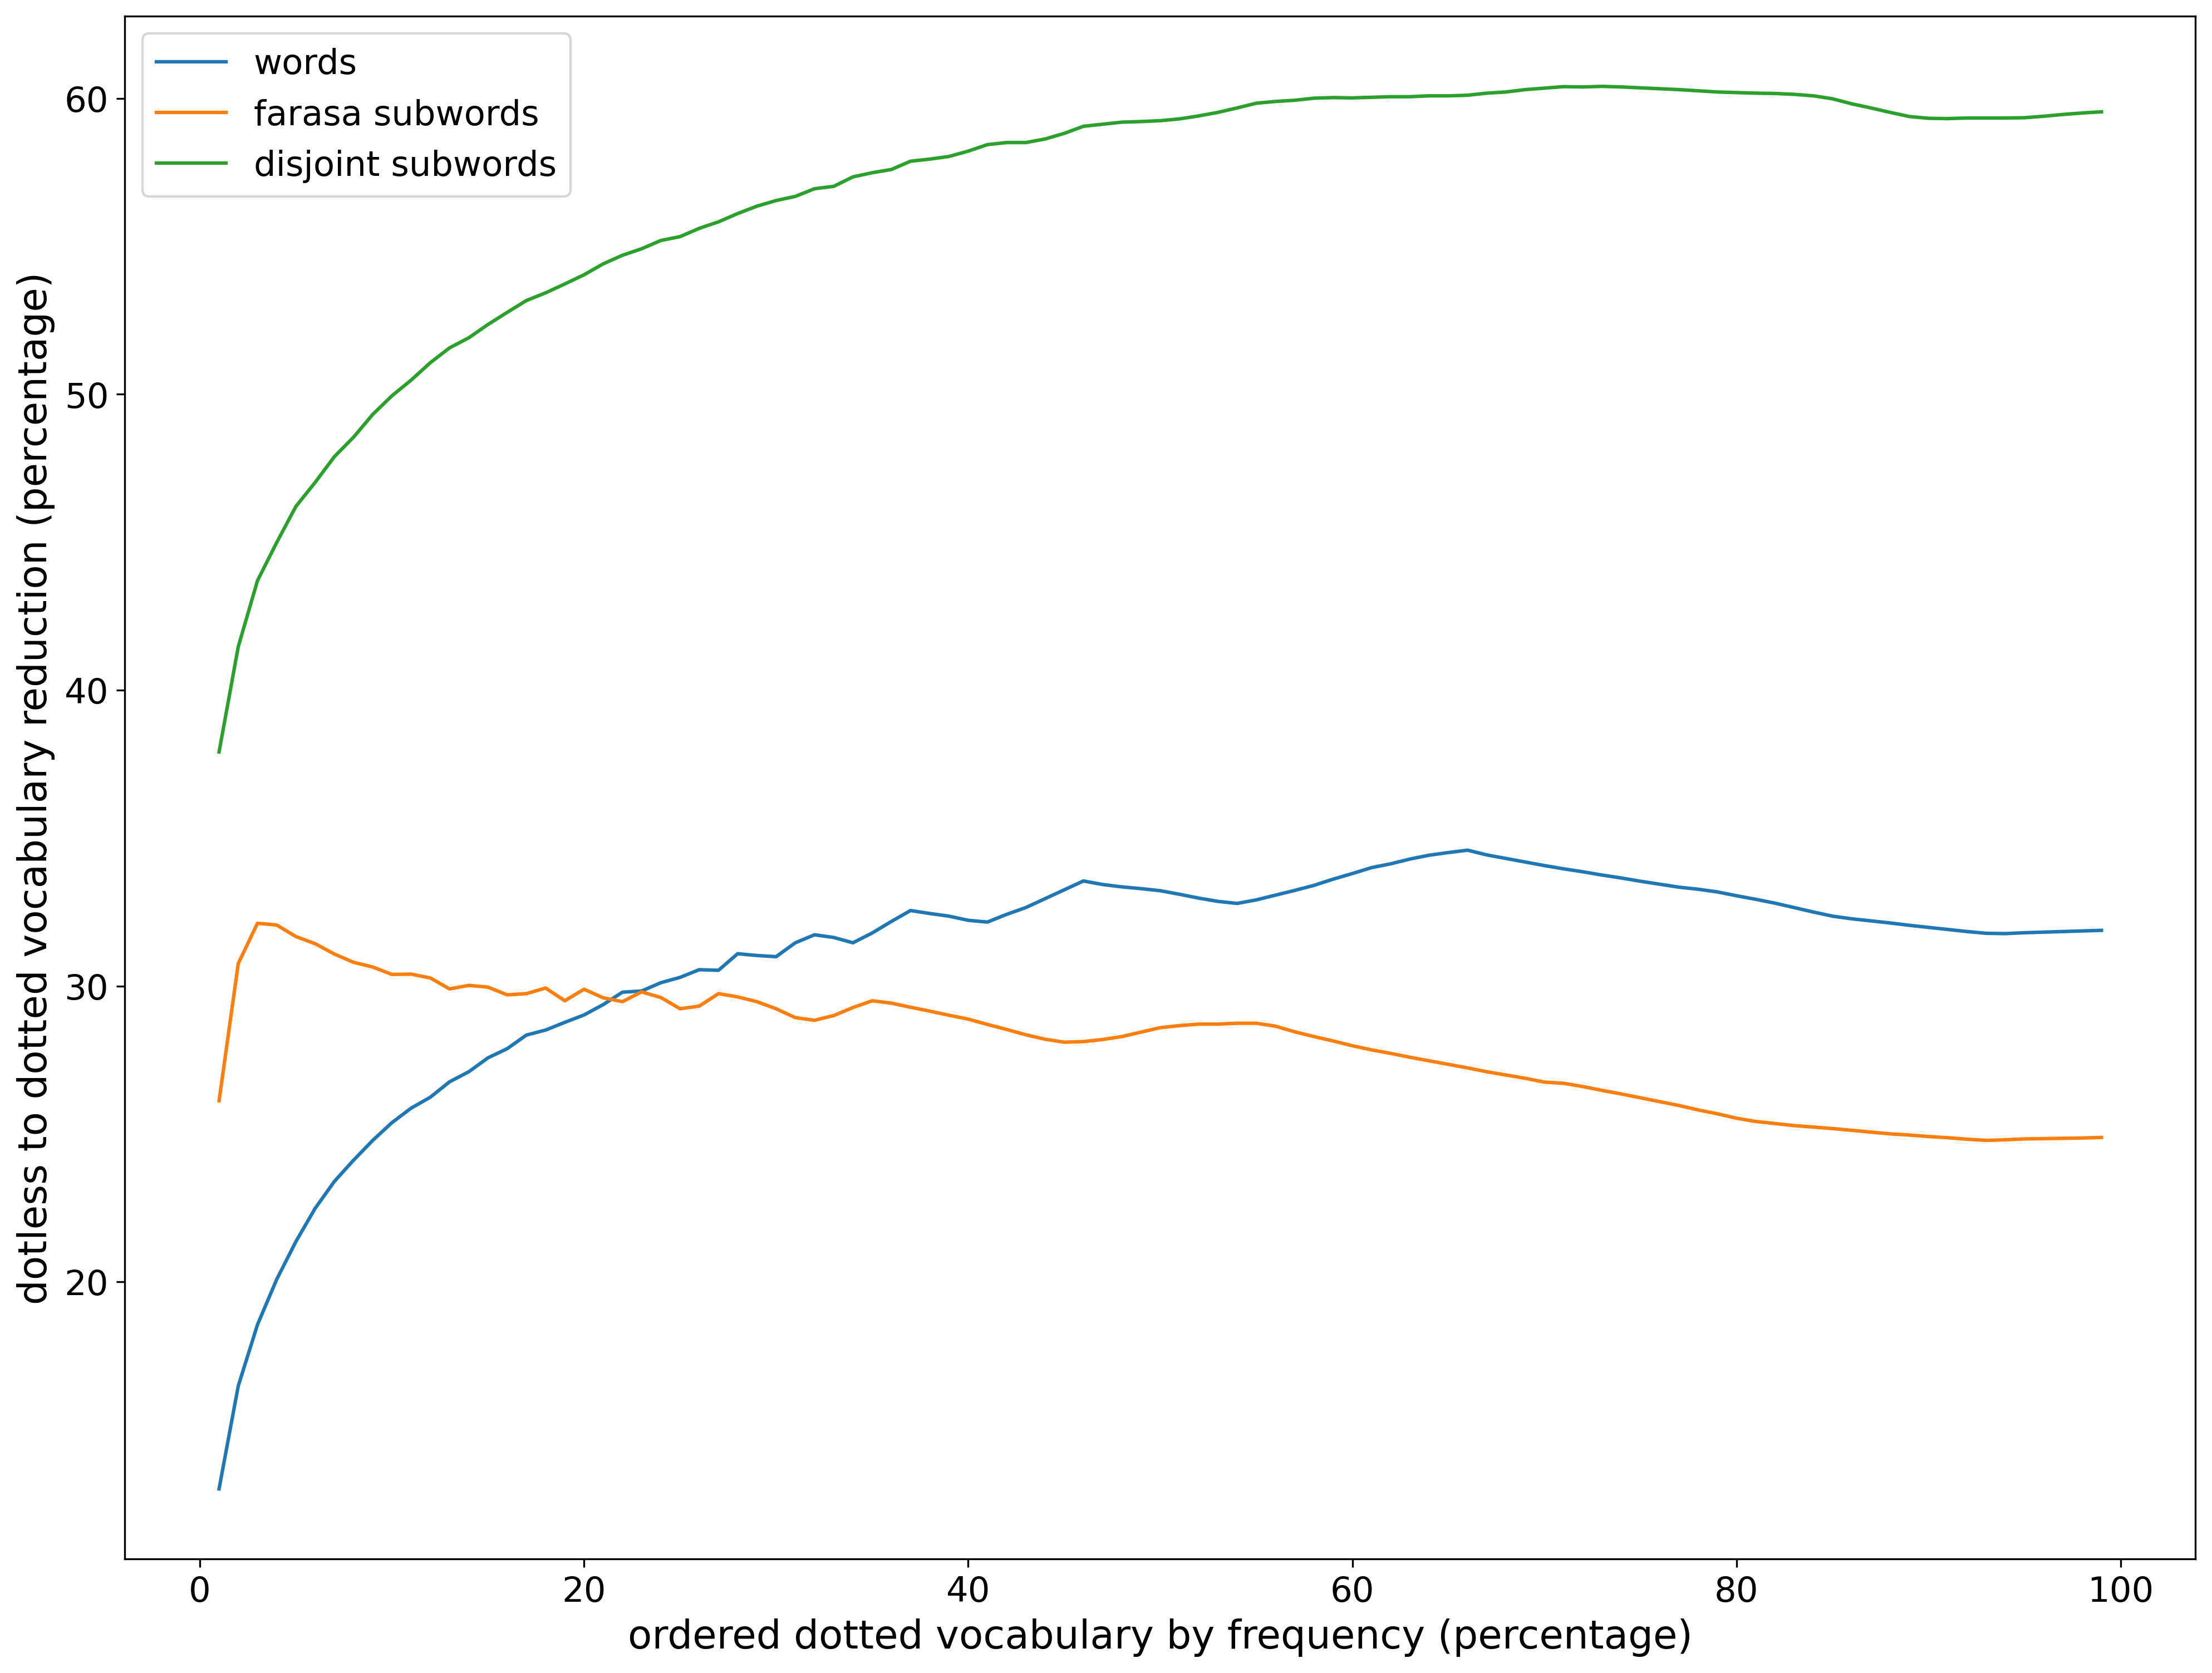

In [9]:
plot()

In [10]:
def plot_multiple(
    counters=[
        words_counter,
        disjoint_counter,
        farasa_counter,
    ],
    counters_names=[
        'words',
        'disjoint subwords',
        'farasa subwords',
    ]
):
    plt.rc('font',size=15)
    figure, axis = plt.subplots(1,3,figsize=(30,10),layout='constrained',dpi=300)
    for i,(counter,counter_name) in enumerate(list(zip(counters,counters_names))):
        X,Y = get_x_y_points(counter_json_str=json.dumps(counter),verbose=False)
        axis[i].plot(
            X,
            Y,
            label=f'{counter_name}',
        )
        axis[i].legend(loc='upper right',fontsize=15)
        
    figure.supxlabel('words',fontsize=15)
    figure.supylabel('dotless words ratio',fontsize=15)

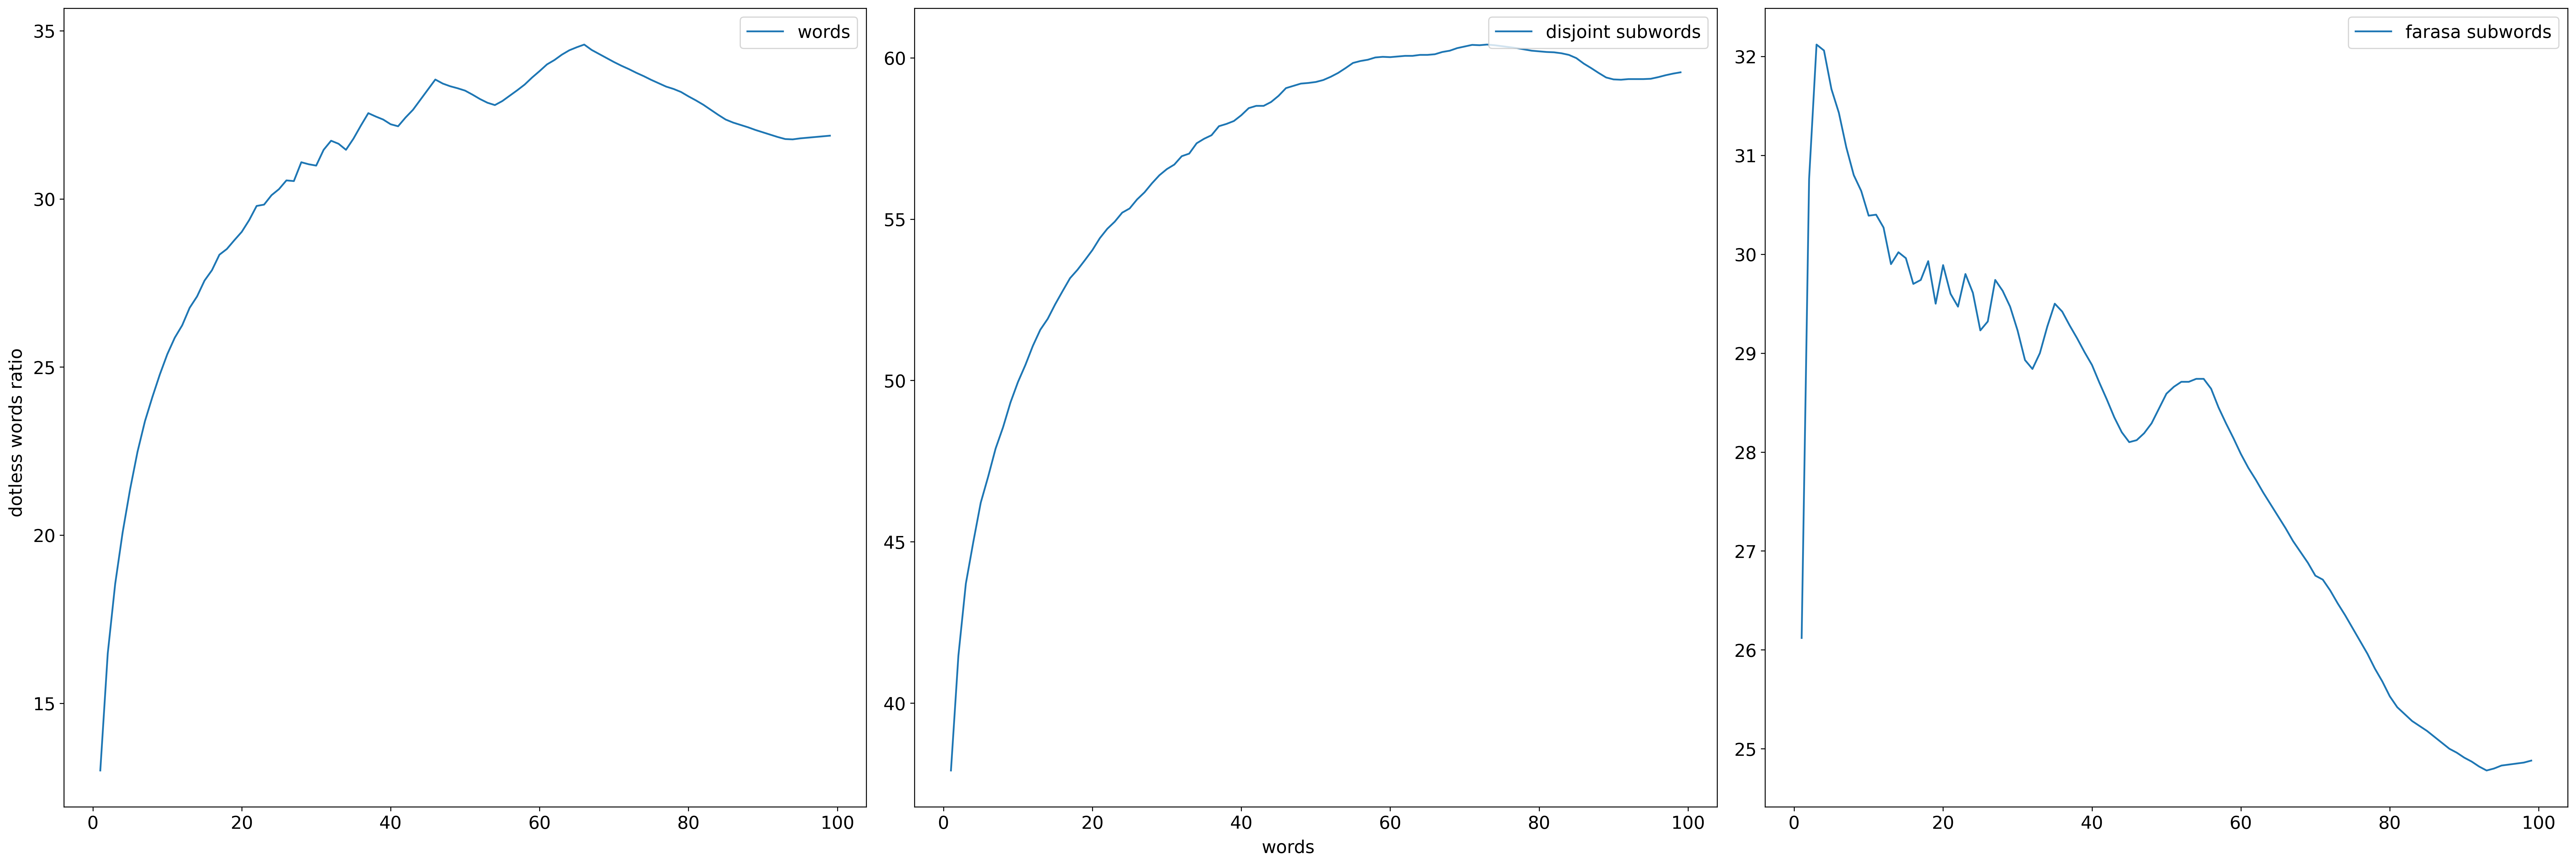

In [11]:
plot_multiple()